In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.5 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 596 kB 70.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 7.1 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 140 kB 74.3 MB/s 
     |████████████████████████████████| 212 kB 36.2 MB/s 
     |████████████████████████████████| 1.1 MB 66.3 MB/s 
     |████████████████████████████████| 127 kB 52.4 MB/s 
     |████████████████████████████████| 144 kB 51.9 MB/s 
     |███████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.tokenize import sent_tokenize
from scipy.special import softmax
from transformers import AutoTokenizer, DefaultDataCollator, TFAutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('punkt')


model_name = "dbmdz/bert-base-italian-xxl-cased"
model_path = "drive/MyDrive/"
train_data_path = "drive/MyDrive/train_data.csv"
test_data_path = "drive/MyDrive/test_data.txt"
predictions_path = "drive/MyDrive/predictions.csv"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_data = pd.read_csv(train_data_path)
X_train = train_data['text']
y_train = train_data['label'].astype(int)

sent_X_train = []
sent_y_train = []
for i, article in enumerate(X_train):
  for sentence in sent_tokenize(article):
    sent_X_train.append(sentence)
    sent_y_train.append(y_train[i])

sent_X_train = pd.DataFrame(sent_X_train)
sent_y_train = pd.DataFrame(sent_y_train)


train_df = pd.concat([sent_X_train, sent_y_train], axis = 1)
train_df.columns = ['text', 'label']
train_dataset = Dataset.from_pandas(train_df)

In [14]:
id2label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

label2id = {
    'EML': 0,
    'NAP': 1,
    'PMS': 2,
    'FUR': 3,
    'LLD': 4,
    'LIJ': 5,
    'LMO': 6,
    'ROA_TARA': 7,
    'SCN': 8, 
    'VEC': 9,
    'SC': 10
}

test_data = []
with open(test_data_path, 'r', encoding='utf-8') as f:
     for line in f:
        sample = line.rstrip().split("\t")
        if len(sample)==2:
          label, clean = sample[0], sample[1]
          label = label2id[label]
          test_data.append([clean, label])
        elif len(sample)==3:
          label, clean = sample[0], sample[1]+sample[2]
          label = label2id[label]
          test_data.append([clean, label])

test_data = pd.DataFrame(test_data)
X_test = test_data.iloc[:, 0]
y_test = test_data.iloc[:, 1]
test_df = pd.concat([X_test, y_test], axis = 1)
test_df.columns = ['text', 'label']
test_df.to_csv(model_path + "test_data.csv")
test_dataset = Dataset.from_pandas(test_df)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(sentence):
    return tokenizer(sentence['text'], padding='max_length', truncation=True, max_length=50)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

  0%|          | 0/697 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [9]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=128,
)

tf_test_dataset = test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=128,
)

In [10]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=11)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(tf_train_dataset,
            epochs=1,
            verbose=2,
            )
  
model.save_pretrained(model_path+model_name)

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5443/5443 - 3762s - loss: 1.9333 - sparse_categorical_accuracy: 0.2776 - 3762s/epoch - 691ms/step


In [11]:
y_pred = model.predict(tf_test_dataset)[0]
y_pred = list(map(lambda x : softmax(x), y_pred))
y_pred = np.argmax(np.array(y_pred), axis=-1)

def write_output(file_name, Y):
  f  = open(file_name, "w")
  for y in Y:
    f.write(str(y) + "\n")
  f.close()

write_output(predictions_path, y_pred)

In [22]:
true_values = np.array(pd.read_csv(model_path + "test_data.csv").iloc[:, 2])[:-1]
predicted_values = np.array(pd.read_csv(predictions_path)).flatten()

model_performance = {}
model_performance['accuracy'] = accuracy_score(true_values, predicted_values)
model_performance['precision_micro'] = precision_score(true_values, predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(true_values, predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(true_values, predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(true_values, predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(true_values, predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(true_values, predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(true_values, predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(true_values, predicted_values, normalize='true')

[6 8 6 ... 8 8 8]
[2 2 2 ... 2 2 2]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.17519858781994704
  f1-micro: 0.17519858781994704
  f1-macro: 0.04259428142267046



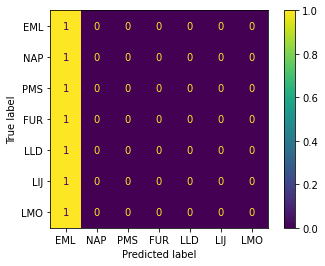

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

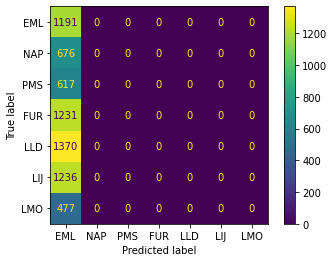

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()